# Diffusion
Physics 177, Spring 2018  
22 May 2018

Stephen Iota

## Discussion

This problem is motivated by Chapter 7 of *Computational Physics, Second Edition* by N. Giordano and H. Nakanishi. 

This is a follow up to **The Drunkard's Walk**. You may now be convinced that the random (drunkard's) walk is really a model for diffusion. In other words, it is a microscopic description of the physics that led to the diffusion equation. 

**Inconsequential Remark**: Here's a deep thought (that's actually a *deep* idea in theoretical physics): the fact that this is a microscopic description that leads to the macroscopic physics of the diffusion equation does not mean that any actual physical system obeying the diffusion equation is described microscopically by a random walk. However, because it maps onto the same macroscopic physics, it doesn't really matter. This is a really heuristic way of describing a program that has come to be known as [renormalization](http://math.ucr.edu/home/baez/renormalization.html).

This notebook examines what happens when one drop of cream falls into a cup of coffee. To aid in plotting, we work in 2 dimensions. The drop is modeled as $N$ cream molecules that start at the origin of a lattice. The molecules are non-interacting and behave as two-dimensional drunkards: at each time step they move randomly. For simplicity, let them move one unit---up, down, left, or right---each time step.

## Problem 1: Single Cream Molecule Drunkard Walk

Simulate the random walk of a single cream molecule starting at the origin of a 2D lattice. 

Use `nStep = 5000` steps. Plot a map of molecule's position on the $x$-$y$ plane for `t` = `10`, `100`, and `1000`.

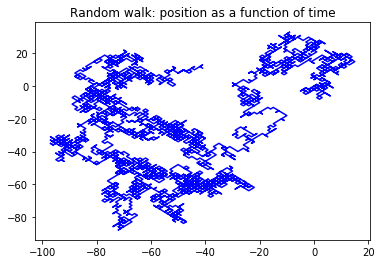

In [1]:
%matplotlib inline
import numpy as np
import random
import matplotlib.pyplot as plt

nStep = 5000
xs = [] # array of x-positions for each time step
ys = [] # array of y-positions for each time step

x = 0
y = 0

for i in range(nStep):
    xs.append(x)
    ys.append(y)
    x += random.randrange(-1,2,2)
    y += random.randrange(-1,2,2)
        
plt.title("Random walk: position as a function of time")
plt.plot(xs, ys, 'b-')
plt.show()

## Problem 2: Diffusion with time

Do the same thing for `nParticles = 400` particles. Because these particles are all independent, this boils down to repeating Problem 1 `nPartcles = 400` times and recording all of the data.

Plot all `nPartcles = 400` simultaneously for `t` = `10`, `100`, and `1000`. You can color code these by time step.

In [2]:
%matplotlib inline
import numpy as np
import random
import matplotlib.pyplot as plt

nStep = 5000 # 5000
nParticles = 400 # 400

particleXdata = [] # array of arrays of x-positions
particleYdata = [] # array of arrays of y-positions

## e.g. particleXdata[i,t] is the x-position of the ith molecule at time step t

for particle in range(nParticles):
    xs = []
    ys = []
    x = 0
    y = 0
    for n in range(nStep):
        xs.append(x)
        ys.append(y)
        x += random.randrange(-1,2,2)
        y += random.randrange(-1,2,2)
        
    particleXdata.append(xs)
    particleYdata.append(ys)

## Convert these into numpy arrays so that matplotlib can use them
xdat = np.array(particleXdata)
ydat = np.array(particleYdata)

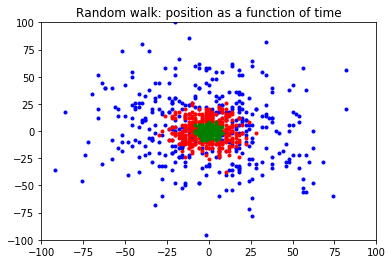

In [3]:
## Plot at different times.
## Make sure you understand how the slices work!

plt.title("Random walk: position as a function of time")
plt.plot(xdat[:,1000], ydat[:,1000], 'b.')
plt.plot(xdat[:,100], ydat[:,100], 'r.')
plt.plot(xdat[:,10], ydat[:,10], 'g.')
plt.xlim(-100, 100) 
plt.ylim(-100, 100)
plt.show()

## Problem 3: Entropy

We would like to determine the entropy, $S$, of the drop-of-cream-in-a-cup-of-coffee system as a function of time. 

$$S = - \sum_{i\in \text{microstates}} P_i \ln  P_i $$

**Remark**: This definition is inspired by the information entropy, or Shannon entropy. You can learn more about this in J. Matchta, "Entropy, information, and computation," [*American Journal of Physics* **67**, 1074 (1999)](https://aapt.scitation.org/doi/10.1119/1.19085) or Styer, "Insight into entropy," [*American Journal of Physics* **68**, 1090 (2000)](https://aapt.scitation.org/doi/abs/10.1119/1.1287353).

We know that entropy is additive for independent subsystems, $S_{A+B} = S_A + S_B$, so it's sufficient just to calculate the entropy of a *single* cream molecule diffusing from the origin. The total entropy is simply `nParticles` times the entropy of a single particle. 

*Why did we simulate 400 of them, then?!* Don't delete that data yet. We'll need it.

In order to calculate $S$, we need to know the probability $P_i$ of each particular microstate. We don't actually know this. (Assume that we don't know the analytic solution to the diffusion equation.) We have some intuition: at early times, we know that it's far more likely for the molecule to be near the origin rather than far from it. In fact, we know that it's *impossible* for the cream molecule to be very far because it only travels at a fixed velocity (one step in space per unit of time). 

### Setting up the problem

In fact, there are two problems:

1. How do we enumerate a "complete" set of "microstates"? (Aren't there an infinite number?)
2. How do we determine the probability $P_i(t)$ of each microstate at a given time step $t$?

We specify the set of microstates as follows:
* We **coarse grain** our system so that there are a managable number of microstates.
* Place the system on a torus by imposing **periodic boundary conditions**. The physics far away from the edges shouldn't be affected by this.


Coarse grain so that $25\times 25$ lattice blocks are identified as a single lattice point. Here's a nice way to do this:

```python
int(round(-x/25))%8
```

Try that out for `x = 27`, `x = -3`, and `x = 30`. If you're confused, try this out for a modulus smaller than 8. 

### Probabilities

In order to determine the probability $P_i(t)$ that a given cream molecule is in a microstate $i$ at time $t$, let's use ensemble of 400 cream molecules that we've already simulated. Take the sample of 400 cream molecules and look at the positions of all 400 molecules at time $t$. To determine the probability of being in, say, the top left corner microstate, $i = (-4,4)$, then we simply count how many of the 400 cream molecules were in that corner and divide by the total number of cream molecules. 

$$
P_i(t) = \frac{\text{number of cream molecules in state } i}{\text{total number of cream molecules}}
$$

Calculate $S(t)$ and plot it. Observe that $S$ is increasing with time as an average, but there are some microscopic fluctuations where it may decrease with time. These fluctuations die out over finite time and large numbers.

In [5]:
## Credit to Adam & Quinten for helping me figure out this cell

%matplotlib inline
import numpy as np
import random
import matplotlib.pyplot as plt

# Number of molecules at each coarse grain block for each time step
# initialize to zero
count_ij = np.zeros((8,8,nStep))

# PERIODIC BOUNDARY CONDITIONS
for time in range(nStep):
    for drunk in range(nParticles):
        x = xdat[drunk,time] # arrays of x-positions at times
        y = ydat[drunk,time] # arrays of y-positions at times
        i = int(round(-x/25))%8
        j = int(round(-y/25))%8
        count_ij[i,j,time] += 1

In [6]:
## Pij[i,j,t] is the probability to be in block (i,j) at time t
Pij = count_ij/nParticles

## Test this for t=4000, should output an 8x8 block of probabilities
print(Pij[:,:,0])

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


In [7]:
from math import log

def entropy(time):
    '''Calculates the entropy for one particular microsystem at one particular time'''
    return -1*time*log(time)    

In [8]:
log(1)

0.0

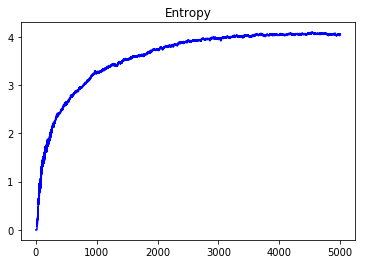

In [9]:
entropies = []
for time in range(nStep): # finding current entropy at each time
    current_ent = 0.0
    for i in range(8):      # for each row
        for j in range(8):  # for each point in row
            if Pij[i,j,time] != 0: # log(0) is undefined
                current_ent += entropy(Pij[i,j,time])
            else:
                current_ent += 0
    entropies.append(current_ent)
#print(entropies)
    
    
plt.title("Entropy")
plt.plot(range(nStep),entropies, 'b-')
plt.show()